In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset
import hashlib


In [2]:
train_concatted = pd.read_csv("/content/drive/MyDrive/ieeecis/train_concatted_v2.csv")
num_trans_cols = pd.read_csv("/content/drive/MyDrive/ieeecis/num_trans_cols_v2.csv", header=None).iloc[:, 0].tolist()

In [3]:
# Separate normal & fraudulent samples
X_normal = train_concatted[train_concatted['isFraud'] == 0]  # Normal transactions
X_anomaly = train_concatted[train_concatted['isFraud'] == 1]  # Fraudulent transactions (for evaluation)

print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

# Drop TransactionID and target variable from train dataset for preprocessing
# train_target = train_transaction["isFraud"]
X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
# X_normal.drop(columns=["isFraud"], inplace=True)
# X_anomaly.drop(columns=["isFraud"], inplace=True)

num_trans_cols.remove("TransactionID")

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
X_normal[num_trans_cols] = scaler.fit_transform(X_normal[num_trans_cols])
X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


# Convert data types to reduce memory usage
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
        elif df[col].dtype == "int64":
            df[col] = df[col].astype("int32")
    return df

#train_df = reduce_memory(train_df)
#test_df = reduce_memory(test_df)
# Final processed datasets
print(f"Train shape: {X_normal.shape}, Test shape: {X_anomaly.shape}")

Train shape: (569877, 252), Test shape: (20663, 252)


<ipython-input-3-1c8cff8eda03>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal.drop(columns=["TransactionID", "isFraud"], inplace=True)
<ipython-input-3-1c8cff8eda03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly.drop(columns=["TransactionID","isFraud"], inplace=True)
<ipython-input-3-1c8cff8eda03>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_normal

Train shape: (569877, 250), Test shape: (20663, 250)


<ipython-input-3-1c8cff8eda03>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_anomaly[num_trans_cols] = scaler.transform(X_anomaly[num_trans_cols])


In [4]:
from sklearn.model_selection import train_test_split
batch_size = 4096
X_train, X_test_normal = train_test_split(X_normal, test_size=0.01, random_state=42)
X_normal_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(X_normal_tensor, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.utils.parametrizations as param
import torch.nn.functional as F



# PyTorch Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, output_dim)

        # Xavier initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        output = self.fc3(z)  # Last layer (no activation)
        return output

# PyTorch Encoder Model
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, latent_dim)

        # Xavier initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x),negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.2)
        x = self.fc3(x)  # Last layer (latent space) has no activation
        return x

# Define Discriminator Dxz
class DiscriminatorXZ(nn.Module):
    def __init__(self, x_dim, z_dim, do_spectral_norm=False):
        """
        Args:
            x_dim (int): Dimensionality of the x input.
            z_dim (int): Dimensionality of the z input.
            do_spectral_norm (bool): If True, apply spectral normalization to linear layers.
        """
        super(DiscriminatorXZ, self).__init__()

        # Helper: apply spectral normalization if desired
        sn = torch.nn.utils.spectral_norm if do_spectral_norm else lambda layer: layer

        # D(x) branch: dense layer -> batch norm -> leaky ReLU
        self.x_fc1 = sn(nn.Linear(x_dim, 128))
        self.x_bn1 = nn.BatchNorm1d(128)

        # D(z) branch: dense layer -> leaky ReLU -> dropout
        self.z_fc1 = sn(nn.Linear(z_dim, 128))
        self.dropout = nn.Dropout(0.5)  # dropout rate 0.5

        # Combined branch (D(x,z)): after concatenation of x and z branches
        self.y_fc1 = sn(nn.Linear(128 + 128, 256))  # concatenated size = 256
        self.y_fc2 = sn(nn.Linear(256, 1))  # output logits

        # Xavier (Glorot) initialization for all linear layers
        nn.init.xavier_uniform_(self.x_fc1.weight)
        nn.init.xavier_uniform_(self.z_fc1.weight)
        nn.init.xavier_uniform_(self.y_fc1.weight)
        nn.init.xavier_uniform_(self.y_fc2.weight)

    def forward(self, x, z):
        # D(x) branch:
        x_out = self.x_fc1(x)
        x_out = self.x_bn1(x_out)
        x_out = F.leaky_relu(x_out,negative_slope=0.2)

        # D(z) branch:
        z_out = self.z_fc1(z)
        z_out = F.leaky_relu(z_out,negative_slope=0.2)
        z_out = self.dropout(z_out)  # dropout is active only in training mode

        # Concatenate the branches along the feature dimension
        y = torch.cat([x_out, z_out], dim=1)

        # Combined branch:
        y = self.y_fc1(y)
        y = F.leaky_relu(y,negative_slope=0.2)
        y = self.dropout(y)

        intermediate_layer = y  # For feature matching

        # Final logits layer (no activation)
        logits = self.y_fc2(y)

        return logits, intermediate_layer


# Define Discriminator Dxx
class DiscriminatorXX(nn.Module):
    def __init__(self, input_dim, do_spectral_norm=False):
        super(DiscriminatorXX, self).__init__()

        # Apply spectral normalization if enabled
        spectral_layer = torch.nn.utils.spectral_norm if do_spectral_norm else lambda x: x

        # Fully connected layers with Spectral Normalization
        self.fc1 = spectral_layer(nn.Linear(input_dim * 2, 256))
        self.fc2 = spectral_layer(nn.Linear(256, 128))
        self.fc3 = spectral_layer(nn.Linear(128, 1))  # Final output layer

        self.dropout = nn.Dropout(0.2)  # Dropout layer

        # Xavier Initialization (equivalent to TensorFlow's `init_kernel`)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x, rec_x):
        # Concatenate x and rec_x
        net = torch.cat([x, rec_x], dim=1)

        # Layer 1
        net = F.leaky_relu(self.fc1(net),negative_slope=0.2)
        net = self.dropout(net) if self.training else net  # Dropout only during training

        # Layer 2
        net = F.leaky_relu(self.fc2(net),negative_slope=0.2)
        net = self.dropout(net) if self.training else net  # Dropout only during training
        intermediate_layer = net

        # # Layer 3 (Logits)
        logits = self.fc3(net)  # No activation in final layer

        return logits, intermediate_layer

# Define Discriminator Dzz
class DiscriminatorZZ(nn.Module):
    def __init__(self, latent_dim, do_spectral_norm=False):
        super(DiscriminatorZZ, self).__init__()

        # If spectral normalization is desired, wrap the linear layers with it.
        sn = torch.nn.utils.spectral_norm if do_spectral_norm else lambda x: x

        # First layer: input dimension is latent_dim * 2 due to concatenation of z and rec_z.
        self.fc1 = sn(nn.Linear(latent_dim * 2, 64))
        # Second layer.
        self.fc2 = sn(nn.Linear(64, 32))
        # Third (output) layer: produces logits.
        self.fc3 = sn(nn.Linear(32, 1))
        # Dropout layer with rate 0.2.
        self.dropout = nn.Dropout(0.2)

        # Xavier initialization (Glorot Uniform)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, z, rec_z):
        # Concatenate along the feature dimension.
        net = torch.cat([z, rec_z], dim=1)

        # Layer 1: Dense -> Leaky ReLU -> Dropout.
        net = F.leaky_relu(self.fc1(net),negative_slope=0.2)
        net = self.dropout(net)  # Dropout is active only in training mode.

        # Layer 2: Dense -> Leaky ReLU -> Dropout.
        net = F.leaky_relu(self.fc2(net),negative_slope=0.2)
        net = self.dropout(net)

        # Save intermediate layer for feature matching.
        intermediate_layer = net

        # Layer 3: Dense to produce logits (no activation).
        logits = self.fc3(net)
        return logits, intermediate_layer



In [13]:
import torch.nn.functional as F
# Training Loop
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
input_dim = X_normal.shape[1]
learning_rate_gen = 1e-3   # Generator (Encoder)
learning_rate_disc_xx = 2e-4 # Discriminator (lower than encoder)
learning_rate_enc = 1e-3
learning_rate_disc_xz = 1e-6
learning_rate_disc_zz = 1e-6
latent_dim = 64
x_dim = input_dim
num_epochs = 50
log_interval = 100
lambda_cycle = 1.0

# Loss function
criterion_s = nn.BCEWithLogitsLoss(reduction='sum')
criterion_m = nn.BCEWithLogitsLoss(reduction='mean')
criterion_n = nn.BCEWithLogitsLoss(reduction='none')

# Move models to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks (example constructors; adapt as needed)
encoder = Encoder(x_dim, latent_dim).to(device)
generator = Generator(latent_dim, x_dim).to(device)
discriminator_xz = DiscriminatorXZ(x_dim, latent_dim,do_spectral_norm=True).to(device)
discriminator_xx = DiscriminatorXX(x_dim,do_spectral_norm=True).to(device)
discriminator_zz = DiscriminatorZZ(latent_dim,do_spectral_norm=True).to(device)


# Optimizers
optimizer_D_xz = optim.Adam(discriminator_xz.parameters(), lr=learning_rate_disc_xz, betas=(0.5, 0.9))
optimizer_D_xx = optim.Adam(discriminator_xx.parameters(), lr=learning_rate_disc_xx, betas=(0.5, 0.9))
optimizer_D_zz = optim.Adam(discriminator_zz.parameters(), lr=learning_rate_disc_zz, betas=(0.5, 0.9))

# Separate optimizers for generator and encoder
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_gen, betas=(0.5, 0.9))
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate_enc, betas=(0.5, 0.9))

# Define a clipping value (adjust as needed)
discriminator_update_interval=2
# recon_criterion = torch.nn.L1Loss()

torch.autograd.set_detect_anomaly(True)

for epoch in range(num_epochs):
    encoder.train()
    generator.train()
    discriminator_xz.train()
    discriminator_xx.train()
    discriminator_zz.train()

    # For logging losses per epoch (average per sample)
    total_loss_D_xz = 0.0
    total_loss_D_xx = 0.0
    total_loss_D_zz = 0.0
    total_loss_G = 0.0
    total_loss_E = 0.0
    n_batches = 0

    for i, real_x in enumerate(train_loader):
        # real_x = real_x.to(device)
        real_x = real_x.type(torch.FloatTensor).to(device)
        # real_x.requires_grad = True
        batch_size = real_x.size(0)
        current_batch_size = batch_size
        n_batches += 1

        # Define labels (adapted: real=0, fake=1)
        # real_labels = torch.ones(batch_size, 1, device=device)
        # fake_labels = torch.zeros(batch_size, 1, device=device)

        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Use 0.9 instead of 1
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)  # Use 0.1 instead of 0

        if i % discriminator_update_interval == 0:
            # ============================
            # 1. Update Discriminator_xz
            # ============================
            optimizer_D_xz.zero_grad()

            # Real pairs: (x, encoder(x))
            z_enc = encoder(real_x)
            logits_real_xz, _ = discriminator_xz(real_x, z_enc)
            loss_real_xz = criterion_m(logits_real_xz, real_labels)

            # Fake pairs: (generator(z_noise), z_noise)
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake = generator(z_noise)
            logits_fake_xz, _ = discriminator_xz(x_fake, z_noise)
            loss_fake_xz = criterion_m(logits_fake_xz, fake_labels)

            loss_D_xz = (loss_real_xz + loss_fake_xz).clone() #(loss_real_xz + loss_fake_xz) / 2
            loss_D_xz.backward()
            optimizer_D_xz.step()

            # ============================
            # 2. Update Discriminator_xx
            # ============================
            optimizer_D_xx.zero_grad()

            # Real pairs: (x, x)
            logits_real_xx, _ = discriminator_xx(real_x, real_x)
            loss_real_xx = criterion_s(logits_real_xx, real_labels)

            # Fake pairs: (x, generator(encoder(x)))
            x_rec = generator(encoder(real_x))
            logits_fake_xx, _ = discriminator_xx(real_x, x_rec)
            loss_fake_xx = criterion_s(logits_fake_xx, fake_labels)

            loss_D_xx = torch.mean(loss_real_xx + loss_fake_xx).clone()  #(loss_real_xx + loss_fake_xx) / 2
            loss_D_xx.backward()
            optimizer_D_xx.step()

            # ============================
            # 3. Update Discriminator_zz
            # ============================
            optimizer_D_zz.zero_grad()

            # Real pairs: (z, z) where z is sampled from the prior (noise)
            z_prior = torch.randn(batch_size, latent_dim, device=device)
            logits_real_zz, _ = discriminator_zz(z_prior, z_prior)
            loss_real_zz = criterion_n(logits_real_zz, real_labels)

            # Fake pairs: (z, encoder(generator(z)))
            x_fake = generator(z_prior)
            z_rec = encoder(x_fake).detach()
            logits_fake_zz, _ = discriminator_zz(z_prior, z_rec)
            loss_fake_zz = criterion_n(logits_fake_zz, fake_labels)

            loss_D_zz = torch.mean(loss_real_zz + loss_fake_zz)#(loss_real_zz + loss_fake_zz) / 2
            loss_D_zz.backward()
            optimizer_D_zz.step()

        #### GEN Code


        z_noise = torch.randn(batch_size, latent_dim, device=device)
        x_fake = generator(z_noise)
        l_generator, _ = discriminator_xz(x_fake, z_noise)
        # Adversarial loss for the generator: now we use real label = 0 (instead of 1)
        gen_loss_xz = criterion_m(l_generator, torch.ones_like(l_generator))

        real_x_clone = real_x.clone()

        # Cycle consistency loss for the x branch:
        # For real x (should be classified as real, i.e., 0)

        x_real_dis, _ = discriminator_xx(real_x_clone, real_x_clone)

        # # Fake pairs: (x, generator(encoder(x)))
        x_real_gen = criterion_s(x_real_dis, torch.zeros_like(x_real_dis))

        x_rec = generator(encoder(real_x_clone))
        x_fake_dis, _ = discriminator_xx(real_x_clone, x_rec)

        # For fake (reconstructed) x (should be classified as fake, i.e., 1)
        x_fake_gen = criterion_s(x_fake_dis, torch.ones_like(x_fake_dis))

        cost_x = torch.mean(x_real_gen + x_fake_gen).clone()

         # # Real pairs: (z, z) where z is sampled from the prior (noise)
        z_prior = torch.randn(batch_size, latent_dim, device=device)
        z_real_dis, _ = discriminator_zz(z_prior, z_prior)

        # # Fake pairs: (z, encoder(generator(z)))
        x_fake = generator(z_prior)
        z_rec = encoder(x_fake)
        z_fake_dis, _ = discriminator_zz(z_prior, z_rec)


        z_real_gen = criterion_n(z_real_dis, torch.zeros_like(z_real_dis))
        z_fake_gen = criterion_n(z_fake_dis, torch.ones_like(z_fake_dis))
        cost_z = torch.mean(z_real_gen + z_fake_gen)

        loss_generator = (gen_loss_xz + lambda_cycle * (cost_x + cost_z)).clone()
        optimizer_G.zero_grad()
        loss_generator.backward()
        optimizer_G.step()


        # # Cycle consistency loss for the z branch:

        # # # Real pairs: (z, z) where z is sampled from the prior (noise)
        # z_prior = torch.randn(batch_size, latent_dim, device=device)
        # z_real_dis, _ = discriminator_zz(z_prior, z_prior)

        # # # Fake pairs: (z, encoder(generator(z)))
        # x_fake = generator(z_prior)
        # z_rec = encoder(x_fake)
        # z_fake_dis, _ = discriminator_zz(z_prior, z_rec)


        # z_real_gen = criterion_n(z_real_dis, torch.zeros_like(z_real_dis))
        # z_fake_gen = criterion_n(z_fake_dis, torch.ones_like(z_fake_dis))
        # cost_z = torch.mean(z_real_gen + z_fake_gen)


        # Total cycle-consistency loss: include z branch if allowed
        # cycle_consistency_loss = cost_x + cost_z
        # cycle_consistency_loss = cost_x.clone()


        # Final losses:

        # For the encoder, we use the loss computed from discriminator_xz.
        l_encoder, _ = discriminator_xz(real_x_clone, encoder(real_x_clone))
        # Adversarial loss for the generator: now we use real label = 0 (instead of 1)
        enc_loss_xz = criterion_m(l_encoder, torch.zeros_like(l_encoder))

        x_real_dis, _ = discriminator_xx(real_x_clone, real_x_clone)
        x_real_gen = criterion_s(x_real_dis, torch.zeros_like(x_real_dis))

        # # Fake pairs: (x, generator(encoder(x)))
        x_rec = generator(encoder(real_x_clone))
        x_fake_dis, _ = discriminator_xx(real_x_clone, x_rec)


        # For fake (reconstructed) x (should be classified as fake, i.e., 1)
        x_fake_gen = criterion_s(x_fake_dis, torch.ones_like(x_fake_dis))

        cost_x = torch.mean(x_real_gen + x_fake_gen).clone()

        # # Real pairs: (z, z) where z is sampled from the prior (noise)
        z_prior = torch.randn(batch_size, latent_dim, device=device)
        z_real_dis, _ = discriminator_zz(z_prior, z_prior)

        # # Fake pairs: (z, encoder(generator(z)))
        x_fake = generator(z_prior)
        z_rec = encoder(x_fake)
        z_fake_dis, _ = discriminator_zz(z_prior, z_rec)


        z_real_gen = criterion_n(z_real_dis, torch.zeros_like(z_real_dis))
        z_fake_gen = criterion_n(z_fake_dis, torch.ones_like(z_fake_dis))
        cost_z = torch.mean(z_real_gen + z_fake_gen)

        loss_encoder = (enc_loss_xz + lambda_cycle * (cost_x + cost_z)).clone()
        optimizer_E.zero_grad()
        loss_encoder.backward()  # No retain_graph needed, last step
        optimizer_E.step()



        # Log per-iteration (average loss per sample)
        total_loss_D_xz += loss_D_xz.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_D_xx += loss_D_xx.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_D_zz += loss_D_zz.item() / current_batch_size if i % discriminator_update_interval == 0 else 0
        total_loss_G    += loss_generator.item() / current_batch_size
        total_loss_E    += loss_encoder.item() / current_batch_size


    # End of epoch: compute and log average losses for discriminators (if updated)
    num_disc_updates = (n_batches // discriminator_update_interval) or 1
    avg_loss_D_xz = total_loss_D_xz / num_disc_updates
    avg_loss_D_xx = total_loss_D_xx / num_disc_updates
    avg_loss_D_zz = total_loss_D_zz / num_disc_updates
    avg_loss_G = total_loss_G / n_batches
    avg_loss_E = total_loss_E / n_batches

    print(f"Epoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Average Loss_D_xz: {avg_loss_D_xz:.4f}  Average Loss_D_xx: {avg_loss_D_xx:.4f} Average Loss_D_zz: {avg_loss_D_zz:.4f}")
    # print(f"  Average Loss_D_xz: {avg_loss_D_xz:.4f}  Average Loss_D_xx: {avg_loss_D_xx:.4f}")
    print(f"  Average Loss_G: {avg_loss_G:.4f}, Average Loss_E: {avg_loss_E:.4f}")

print("Training Complete!")


Epoch [1/50] Summary:
  Average Loss_D_xz: 2.7371  Average Loss_D_xx: 13670.4392 Average Loss_D_zz: 0.0013
  Average Loss_G: 549.5845, Average Loss_E: 542.3077
Epoch [2/50] Summary:
  Average Loss_D_xz: 5.4525  Average Loss_D_xx: 11054.9384 Average Loss_D_zz: 0.0022
  Average Loss_G: 43.1460, Average Loss_E: 39.6273
Epoch [3/50] Summary:
  Average Loss_D_xz: 4.2775  Average Loss_D_xx: 3298.4888 Average Loss_D_zz: 0.0018
  Average Loss_G: 187.5992, Average Loss_E: 118.4719
Epoch [4/50] Summary:
  Average Loss_D_xz: 3.4734  Average Loss_D_xx: 685.2099 Average Loss_D_zz: 0.0021
  Average Loss_G: 329.0814, Average Loss_E: 218.0547
Epoch [5/50] Summary:
  Average Loss_D_xz: 1.4424  Average Loss_D_xx: 128.6648 Average Loss_D_zz: 0.0018
  Average Loss_G: 140.5616, Average Loss_E: 116.2702
Epoch [6/50] Summary:
  Average Loss_D_xz: 1.1222  Average Loss_D_xx: 39.7489 Average Loss_D_zz: 0.0021
  Average Loss_G: 60.8459, Average Loss_E: 52.8149
Epoch [7/50] Summary:
  Average Loss_D_xz: 1.1237  A

In [52]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# --- Sampling ---
num_samples_normal = X_normal.shape[0]
num_samples_anomaly = X_anomaly.shape[0]
# Sample from your normal and anomaly DataFrames (assume these are defined)
# X_test_normal_sampled = X_test_normal.sample(n=num_samples_normal, random_state=42)
# X_anomaly_sampled = X_anomaly.sample(n=num_samples_anomaly, random_state=42)
# X_test_normal_sampled = X_normal
# X_anomaly_sampled = X_anomaly
# X_anomaly_sampled = X_test_normal_sampled

# Create combined test dataset and labels
X_test = pd.concat([X_normal, X_anomaly])
y_test = np.concatenate([np.zeros(num_samples_normal, dtype=int),
                         np.ones(num_samples_anomaly, dtype=int)])

# --- Shuffling ---
# Shuffle the rows of X_test and y_test together
# shuffled_indices = np.random.permutation(X_test.index)
# X_test_shuffled = X_test.loc[shuffled_indices]
# y_test_shuffled = y_test[np.argsort(shuffled_indices)]  # This works if shuffled_indices is sorted;
# Alternatively, we can use:
# y_test_shuffled = y_test[list(shuffled_indices)]

# --- Conversion to Tensors ---
# Convert the shuffled DataFrame and labels to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_x_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create a TensorDataset and DataLoader
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)
batch_size = 4096  # Adjust as needed
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes
print("Test X tensor shape:", test_x_tensor.shape)
print("Test Y tensor shape:", test_y_tensor.shape)


Test X tensor shape: torch.Size([590540, 250])
Test Y tensor shape: torch.Size([590540])


In [54]:
import time
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import average_precision_score

encoder.eval()
generator.eval()
discriminator_xx.eval()

anomaly_scores = []
y_true = []
inference_times = []

def compute_anomaly_score_combined(cnn_codes_orig, cnn_codes_rec, alpha=0.5):
    """
    Computes the anomaly score as a weighted combination of the L1 and L2 norms.
    alpha: weight for L1 loss (between 0 and 1). (1-alpha) is the weight for L2 loss.
    """
    l1_score = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
    l2_score = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
    # Combine the scores.
    combined_score = alpha * l1_score + (1 - alpha) * l2_score
    return combined_score

with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        labels = labels.to(device)

        start_time = time.time()

        # 1. Get CNN codes for original samples from Dxx.
        #    Here, we assume model_Dxx(x) returns (logits, cnn_code)
        _, cnn_codes_orig = discriminator_xx(x_batch,x_batch)

        # 2. Compute reconstruction x_rec = G(E(x))
        z = encoder(x_batch)
        x_rec = generator(z)

        # 3. Get CNN codes for reconstructed samples.
        _, cnn_codes_rec = discriminator_xx(x_rec,x_rec)

        # 4. Compute the L1 reconstruction error in the feature space (per sample).
        #    Using mean absolute error (you could also use sum).
        # batch_scores = torch.mean(torch.abs(cnn_codes_orig - cnn_codes_rec), dim=1)
        # batch_scores = torch.norm(cnn_codes_orig - cnn_codes_rec, p=2, dim=1)
        batch_scores = compute_anomaly_score_combined(cnn_codes_orig,cnn_codes_rec,alpha=0.5)

        anomaly_scores.extend(batch_scores.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())
        # Record and store the inference time for this batch.
        batch_inference_time = time.time() - start_time
        inference_times.append(batch_inference_time)

print("y_true: {}".format(y_true[:5]))
print("anomaly_scores: {}".format(anomaly_scores[:5])) # Access the first element of the desired rows using slicing

# Compute AUROC using the anomaly scores.
auroc = roc_auc_score(y_true, anomaly_scores)
print("AUROC: {:.4f}".format(auroc))

# Calculate average inference time over all batches.
mean_inference_time = np.mean(inference_times)
print("Mean inference time per batch: {:.4f} sec".format(mean_inference_time))

# Assume y_true is a list/array of true labels (0 for normal, 1 for anomaly)
# and anomaly_scores is a list/array of your model's anomaly scores
average_precision = average_precision_score(y_true, anomaly_scores)
print("Average Precision (AUPRC): {:.4f}".format(average_precision))


y_true: [0, 0, 0, 0, 0]
anomaly_scores: [0.5784403681755066, 0.4878670573234558, 0.39517101645469666, 0.08183398097753525, 0.5680821537971497]
AUROC: 0.5219
Mean inference time per batch: 0.0033 sec
Average Precision (AUPRC): 0.0365


In [55]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Suppose these are defined from your ALAD model inference:
# y_true: true labels, e.g. np.array([...])
# anomaly_scores: continuous anomaly scores, e.g. np.array([...])

# Convert lists to numpy arrays if necessary.
y_true = np.array(y_true)
anomaly_scores = np.array(anomaly_scores)

# Option 1: Determine threshold using the 95th percentile of normal samples.
# (Assumes that normal samples are labeled 0.)
normal_scores = anomaly_scores[y_true == 0]
threshold = np.percentile(normal_scores, 90)
print("Threshold based on 95th percentile of normal samples:", threshold)

# Option 2: Or set a manual threshold (uncomment below if needed).
# threshold = 0.5

# Generate binary predictions: predict fraud (1) if score > threshold, else normal (0)
y_pred = (anomaly_scores > threshold).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))


Threshold based on 95th percentile of normal samples: 36.39354400634766
Precision: 0.0375
Recall: 0.1074
F1 Score: 0.0556


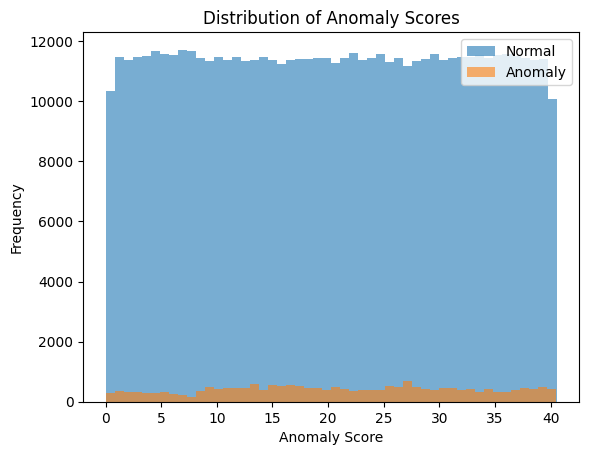

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_true and anomaly_scores are NumPy arrays
# where y_true==0 for normal and y_true==1 for anomalies.


normal_scores = anomaly_scores[y_true == 0]
anomaly_scores_only = anomaly_scores[y_true == 1]

plt.hist(normal_scores, bins=50, alpha=0.6, label='Normal')
plt.hist(anomaly_scores_only, bins=50, alpha=0.6, label='Anomaly')
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.legend()
plt.show()

AUPRC (using auc function): 0.0365
AUPRC (using average_precision_score): 0.0365


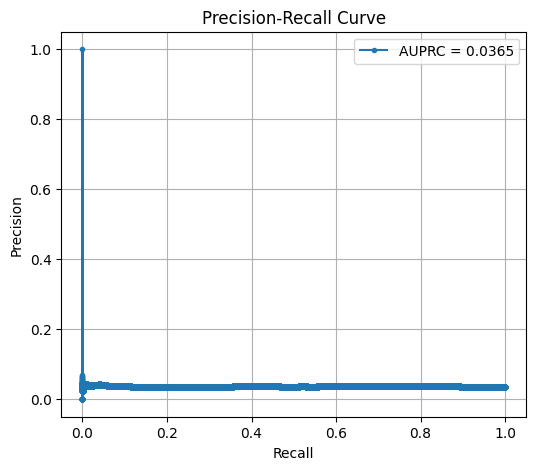

In [57]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, anomaly_scores)

# Compute AUPRC (Area Under PR Curve)
auprc = auc(recall, precision)  # Using AUC function
ap_score = average_precision_score(y_true, anomaly_scores)  # Direct AUPRC score

print(f"AUPRC (using auc function): {auprc:.4f}")
print(f"AUPRC (using average_precision_score): {ap_score:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()